In [1]:
292701

292701

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Tarefa 3 - Neural Networks
Third assessed coursework for the course: Técnicas e Algoritmos em Ciência de Dados

This tarefa provides an exciting opportunity for students to put their knowledge acquired in class into practice, using neural networks to solve real-world problems in both classification and regression. Students will apply the concepts they have learned to build, train, and optimize neural networks, using a validation set to fine-tune hyperparameters. Students will also get used to generating important plots during training to analyse the models' behaviour. By the end of the project, students will have gained hands-on experience in implementing neural networks.

## General guidelines:

* This work must be entirely original. You are allowed to research documentation for specific libraries, but copying solutions from the internet or your classmates is strictly prohibited. Any such actions will result in a deduction of points for the coursework.
* Please enter your code in the designated areas of the notebook. You can create additional code cells to experiment with, but __make sure to place your final solutions where they are requested in the notebook.__
* Before submitting your work, make sure to rename the file to the random number that you created for the previous coursework (for example, 289479.ipynb).

## Notebook Overview:

1. [Regression](#Regression) (50%)
2. [Classification](#Classification) (50%)

# Regression

**Download from ECLASS**
- Tarefa_3_template.ipynb
- energy_efficiency.csv

**Dataset and Problem Description**

In this exercise, you will use the Energy Efficiency Prediction dataset. This dataset contains information about the energy efficiency of buildings based on eight features, including the size of the building, the orientation, and the type of building materials used. The dataset includes two targets: heating load and cooling load, which represent the energy required to heat and cool the building, respectively.

This dataset is useful for building neural networks that predict the energy efficiency of buildings, which is an important problem in the field of sustainable energy. The dataset has been used in several machine learning research papers and provides a challenging regression problem.

**Exercise Description: Energy Efficiency Prediction with Neural Networks**

In this exercise, you will use the Energy Efficiency Prediction dataset provided.
You will build and train a neural network to predict the heating load (column labelled y1 in the dataset) and the cooling load (column labelled y2) of a building based on its energy efficiency features. 


### To complete this exercise, you will write code to build and train neural networks for this problem:

1. Split the dataset into training, validation, and test sets, using a 70:15:15 ratio.

2. Use numpy, build a neural network that takes the energy efficiency features as input and predicts the heating and the cooling load as outputs. You will choose the number of neurons per layers and the number of layers, but each layer will have the same number of neurons. These two values must be input parameters for your neural network. That is, you can’t hard-code each layer, meaning that you will have to write code that is able to work with a variable number of layers and neurons. 

3. Code the forward pass and backpropagation algorithm to learn the weights of the neural network. Use the training set to train the neural network and update the weights using stochastic gradient descent. For the hidden layers use the sigmoid activation function. You will need to regularize your neural network using weight decay, that is, you will include a regularization term in your error function.

4. Monitor the training by plotting the training and validation losses across the epochs. 

The performance of your neural network will be different depending on the number of layers, number of neurons per layer and the value of λ that controls the amount of weight decay. You will experiment with 3 values of λ: 0 (no weight decay), 0.001 and 0.0001.
To choose the best network configuration and assess its performance you will:

1. Choose 3 possible values of number hidden layers (for example, 1 to 3) and 3 different values of neurons per layer (for example, 100, 200, and 300), but you can also choose different values. 

2. Calculate the loss for each configuration on the validation set.

3. Generate 3 heatmaps, one for each value of the λ regularization parameter, displaying the loss on the validation set by plotting the number of layers and number of neurons in a grid. This will help you visualise the best configuration for the neural network. 

4. Train your final model selecting the best combination of hyper-parameters and evaluate the final performance of the neural network using the test set and the root mean squared error as the metric and report that.

**Important:**
- Train for 50 epochs.
- Set the learning rate η to 0.01.


In [3]:
## your code goes here:
# Reading csv and separating between data and target
random_state = 49
data = pd.read_csv("./energy_efficiency.csv")
X = data.values[:,:-2]
y = data.values[:,-2:]
# Spliting the data
X_train, X_tv, y_train, y_tv = train_test_split(X, y, test_size=0.3, random_state=random_state)
X_test, X_val, y_test, y_val = train_test_split(X_tv, y_tv, test_size=0.5, random_state=random_state)

In [4]:
# Auxiliar functions
def rmse(y_pred: np.ndarray, y_real: np.ndarray) -> float:
    return np.sqrt(np.mean(np.power(y_pred - y_real, 2)))

def sse(y_pred: np.ndarray, y_real: np.ndarray) -> float:
    return np.sum(np.power(y_pred - y_real, 2))/2

def sigmoid_activation(z: np.ndarray) -> np.ndarray:
    z = z.astype(float)
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z: np.ndarray) -> np.ndarray:
    return sigmoid_activation(z) * (1 - sigmoid_activation(z))

def gen_weights_bias(nlines: int, ncols: int, std: float = 1) -> list[np.ndarray]:
    weights_bias_dict = {
        "W": np.random.normal(size=(nlines, ncols), scale=std),
        "b": np.random.normal(size=(ncols, 1), scale=std)
    }
    return weights_bias_dict

def get_output_network(X: np.ndarray, network: dict, output_activation=lambda x: x, activation=sigmoid_activation) -> np.ndarray:
    # Function to get the predction based on the netowork given
    pred = X @ network[0]["W"] + network[0]["b"].T
    for i in range(1, len(network)):
        pred = activation(pred) @ network[i]["W"] + network[i]["b"].T
    return output_activation(pred)

def plot_historic_error(historic:list, loss_func:str='RMSE', y_lim:float=0.2):
    if len(historic) == 2:
        plt.plot(historic[0], color='orange', label='Train Set')
        plt.plot(historic[1], color='green', label='Validation Set')
    else:
        plt.plot(historic, color='red', label='Train Set')
    plt.legend()
    plt.title('Training Loss')
    plt.ylim(0, y_lim)
    plt.ylabel(loss_func)
    plt.xlabel('Epochs')
    plt.show()

Train Results: 0.088
Validation Results: 0.082


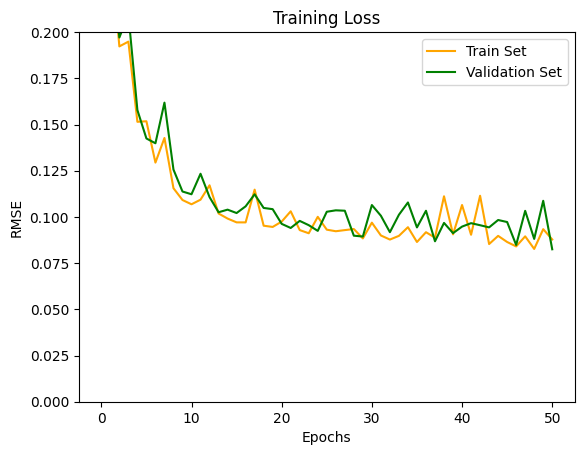

In [5]:
def forward_pass(X:np.ndarray, network:dict, activation=sigmoid_activation) -> dict:
    layers = dict()
    # Activate the layers (without output function)
    layers[0] = X @ network[0]["W"] + network[0]["b"].T
    
    for i in range(1, len(network)):
        layers[i] = activation(layers[i-1]) @ network[i]["W"] + network[i]["b"].T

    return layers

def backpropagation(X:np.ndarray, y:np.ndarray, network:dict, layers:dict,
                    wd:float, lr:float, activation=sigmoid_activation, Der_activation=sigmoid_derivative) -> dict:
    # Start by calculating the first error
    error = layers[len(layers)-1] - y

    for layer in range(len(layers)-1, 0, -1):
        # Then get the firsts gradients of weights and biases
        gradient_w = activation(layers[layer-1]).T @ error
        gradient_b = np.sum(error, axis=0).reshape(-1, 1)
        # Then update the weights and baises
        network[layer]["W"] -= lr * (gradient_w + wd * network[layer]["W"])
        network[layer]["b"] -= lr * gradient_b
        # Finally update the error in each interation
        error = (error @ network[layer]["W"].T) * Der_activation(layers[layer-1])
    # Then do the last updates of the loop
    gradient_w = X.T @ error
    gradient_b = np.sum(error, axis=0).reshape(-1, 1)

    network[0]["W"] -= lr * (gradient_w + wd * network[0]["W"])
    network[0]["b"] -= lr * gradient_b

    return network

def regression_network(X:np.ndarray, y_real:np.ndarray, neurons_amount:int, layers_num:int,
                         epochs:int, weight_decay:float, learning_rate:float=0.01, val_set=None) -> list[list[np.ndarray]]:
    # Initialize the network with random values
    model_dict = dict()

    if layers_num == 1:
        model_dict[0] = gen_weights_bias(X.shape[1], y_real.shape[1])
    else:
        model_dict[0] = gen_weights_bias(X.shape[1], neurons_amount)

        if layers_num > 2:
            for i in range(1, layers_num-1):
                model_dict[i] = gen_weights_bias(neurons_amount, neurons_amount)
                
        model_dict[layers_num-1] = gen_weights_bias(neurons_amount, y_real.shape[1])

    loss_historic_train = list()
    loss_historic_val = list()
    # Calculate the loss without any training
    loss_current = rmse(get_output_network(X, model_dict), y_real)
    loss_historic_train.append(loss_current)
    if val_set != None:
        loss_current = rmse(get_output_network(val_set[0], model_dict), val_set[1])
        loss_historic_val.append(loss_current)

    # For each epoch we ran our train again
    for epoch in range(epochs):
        # Permutate the indices to exclude a vies
        indices = np.random.permutation(len(X))
        X_permuted = X[indices]
        y_permuted = y_real[indices]

        # Start the Stochastic Gradient Descendent method
        for i in range(len(X)):
            # Get a sample of X and y permuted as line vectors
            x_sample = X_permuted[i].reshape(1, -1)
            y_sample = y_permuted[i].reshape(1, -1)
            
            # Do the forward pass for the layers
            layers = forward_pass(x_sample, model_dict)
            # Start the backpropagation
            model_dict = backpropagation(x_sample, y_sample, model_dict, layers,
                                         wd=weight_decay, lr=learning_rate)
        # After updated weights and biases based on each sample, recalculate the loss
        loss_current = rmse(get_output_network(X, model_dict), y_real)
        loss_historic_train.append(loss_current)
        if val_set != None:
            loss_current = rmse(get_output_network(val_set[0], model_dict), val_set[1])
            loss_historic_val.append(loss_current)
    if val_set != None:
        loss_historic = [loss_historic_train, loss_historic_val]
    else:
        loss_historic = loss_historic_train
    # Then return the model and losses
    return model_dict, loss_historic
    

network, historic = regression_network(X_train, y_train, 50, 3, 50, 0, 0.01, [X_val, y_val])
print(f"Train Results: {historic[0][-1]:.3f}\nValidation Results: {historic[1][-1]:.3f}")
plot_historic_error(historic)

In [6]:
def get_losses(train_set:list, val_set:list, weight_decay:float, layers:list, neurons:list, loss_func=rmse):
    results = pd.DataFrame(columns=neurons, index=layers)
    
    for layer in layers:
        for neuron in neurons:
            network, historic = regression_network(train_set[0], train_set[1], neuron, layer, 50, weight_decay, 0.01)
            results.loc[layer, neuron] = loss_func(get_output_network(val_set[0], network), val_set[1])

    return results.astype(float)

In [7]:
layers = [1, 4, 5]
neurons = [50, 100, 150]
# Get the results for the configurations above

In [8]:
results_1 = get_losses([X_train, y_train], [X_val, y_val], 0, layers, neurons)

In [9]:
results_2 = get_losses([X_train, y_train], [X_val, y_val], 0.001, layers, neurons)

In [10]:
results_3 = get_losses([X_train, y_train], [X_val, y_val], 0.0001, layers, neurons)

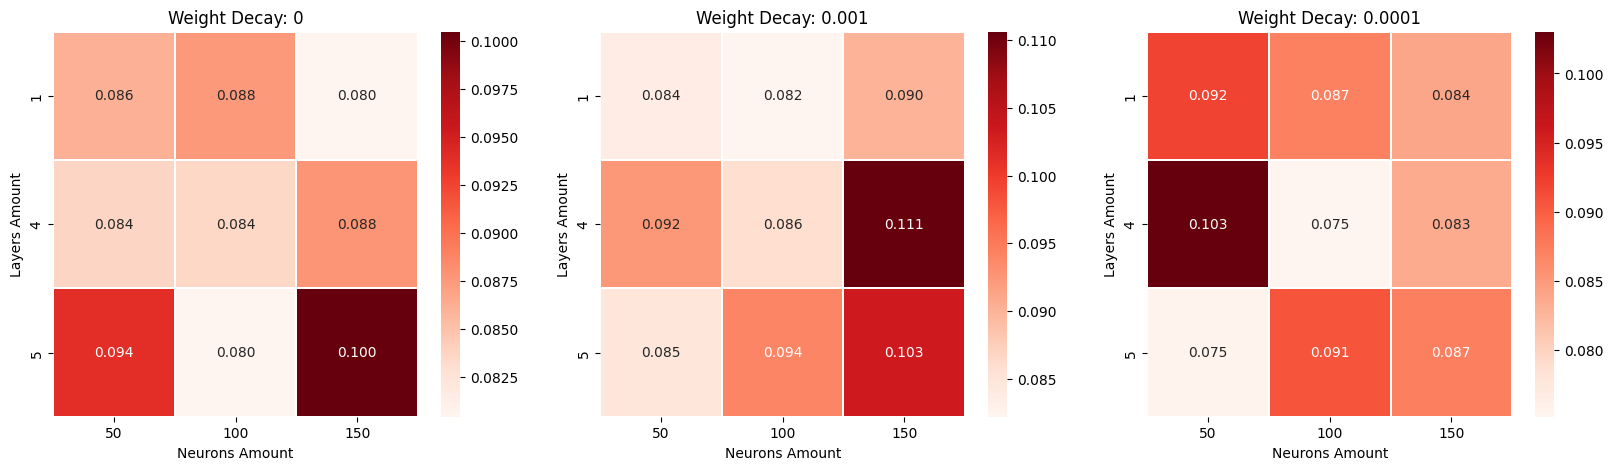

In [11]:
# THen plot the 3 heatmaps
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

sns.heatmap(results_1, annot=True, fmt=".3f", linewidth=.2, cmap='Reds', ax=ax[0])
ax[0].set(xlabel='Neurons Amount', ylabel='Layers Amount', title='Weight Decay: 0')

sns.heatmap(results_2, annot=True, fmt=".3f", linewidth=.2, cmap='Reds', ax=ax[1])
ax[1].set(xlabel='Neurons Amount', ylabel='Layers Amount', title='Weight Decay: 0.001')

sns.heatmap(results_3, annot=True, fmt=".3f", linewidth=.2, cmap='Reds', ax=ax[2])
ax[2].set(xlabel='Neurons Amount', ylabel='Layers Amount', title='Weight Decay: 0.0001')

plt.show()

In [13]:
# Concat train and validation data
X_train_val = np.concatenate([X_train, X_val]) 
y_train_val = np.concatenate([y_train, y_val])

# Choose the best ones
weight_decay = 0.001
neurons_amount = 100
layers_num = 4

network, historic = regression_network(X_train_val, y_train_val, neurons_amount, layers_num, 50, weight_decay, 0.01)
# Get the rmse for the test set
rmse_test = rmse(get_output_network(X_test, network), y_test)
print(f"RMSE for test set: {rmse_test}")

RMSE for test set: 0.07901773717260407


# Classification

**Download the data from ECLASS**
- drug_side_effects.csv
- drug_features.csv

**Dataset description:**

In this exercise, you will build and train a neural network to predict the occurrence of drug side effects. The dataset is derived from the SIDER dataset, containing relatively common side effects that can occur for at least 50 drugs. This produces a total of 740 drugs and 256 side effects. The features represent various molecular properties, including molecular weight, number of atoms, number of rings, number of hydrogen bond donors and acceptors, logP, topological polar surface area (TPSA), number of rotatable bonds, number of aromatic rings, number of aliphatic rings, number of saturated rings, and number of heteroatoms. 

**Remember that each drug can cause many side effects, not only one.** 

*Feel free to explore the dataset and check the potential side effects of popular medications!*

### To complete this exercise, follow these steps:

1. Load the dataset and split it into training, validation, and test sets, using an 80:10:10 ratio. 

2. Standardize the features by removing the mean and scaling to unit variance. To do this, perform the following for each feature (column) in the dataset:
    - Calculate the mean and standard deviation across the training set for that feature.
    - Subtract the mean from each value in that feature and divide by the standard deviation.
    - Apply the same transformation to the validation and test sets using the mean and standard deviation calculated from the training set.

**Observation:** you need to code this part, you’re not allowed to use scikit-learn.

*Normalization of features is important for neural networks because:*
- *It ensures that all features have the same scale, preventing certain features from dominating the learning process due to their larger magnitude.*
- *It improves the numerical stability of the training process, making the neural network less sensitive to the choice of learning rate and other hyperparameters.*

3. Build a neural network using NumPy that takes in the features as input and predicts the occurrence of side effects. You will choose the number of neurons per layer and the number of layers. You will provide this information as an input list where the length of the list determines the number of hidden layers, and each element is the number of neurons of that hidden layer. For example, an array `layers = [64,128,256]` should produce a network with 4 layers, with 3 hidden layers with 64, 128, and 256 neurons each. For the hidden layers use the sigmoid activation function. You will need to regularize your neural network using weight decay, that is, you will include a regularization term in your error function.

4. Code the forward pass and backpropagation algorithm to learn the weights of the neural network. Use the training set to train the neural network and update the weights using stochastic gradient descent. Don’t forget about the biases. 

5. Monitor the training by plotting the training and validation losses across the epochs.

	**Observation:** make sure the loss goes down during training, acceptable values are within 0.2 – 2.8 approximately. These values depend on the choice of the different hyperparameters. Test only sensible values taking into account the dataset, i.e., number of features, drugs, side effects. 

The performance of your neural network will be different depending on the number of layers, number of neurons per layer and the value of λ that controls the amount of weight decay. You will experiment with 3 values of λ: 0 (no weight decay), 1 and 0.01.
To choose the best network configuration and assess its performance you will:

1. For each value of λ, select 3 different layer configurations (note that in this exercise, the number of neurons per layer does not require to be the same for each layer).
2. Calculate the loss for each configuration on the validation set.
3. At the end of this process, you should be left with 9 loss values (one for each configuration). Train your final model selecting the best combination of hyper-parameters and evaluate the final performance of the neural network using the test set and the Area Under the ROC Curve (AUROC) with the function provided in the Jupyter notebook. 
	
	*Observation: don’t expect impressive AUROC values, as this is a highly complex problem that can’t be solved easily with a simple neural network with standard features. Expect values in the range (0.55-0.75).*

**Important:**
- Train for 50 epochs.
- Set the learning rate η to 0.01.



In [14]:
## your code goes here:
drug_side_effects = pd.read_csv("drug_side_effects.csv")
drug_features = pd.read_csv("drug_features.csv")

X = drug_features.values[:,1:].astype(float)
y = drug_side_effects.values[:,1:].astype(float)

X_train, X_tv, y_train, y_tv = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_test, X_val, y_test, y_val = train_test_split(X_tv, y_tv, test_size=0.5, random_state=random_state)

In [15]:
# Auxiliar functions
def normalize_data(data: np.ndarray) -> np.ndarray:
    for col in range(data.shape[1]):
        data[:, col] = (data[:, col] - np.mean(data[:, col])) / np.std(data[:, col])
    return data.astype(float)

def normalize_all_data(*args: list[np.ndarray]) -> list[np.ndarray]:
    normalized = []
    for arg in args:
        normalized.append(normalize_data(arg))
    return normalized

# Data normalization
X_train, X_test, X_val = normalize_all_data(X_train, X_test, X_val)

def binary_cross_entropy(y_pred: np.ndarray, y_real: np.ndarray) -> float:
    return -np.mean(y_real * np.log(y_pred + 1e-8) + (1 - y_real) * np.log(1 - y_pred + 1e-8))

def cross_entropy(y_pred: np.ndarray, y_real: np.ndarray) -> float:
    sigma = 1e-8
    entropy = y_real * np.log(y_pred + sigma) + (1 - y_real) * np.log(1 - y_pred + sigma)
    return -np.mean(entropy)

Train Loss: 0.407


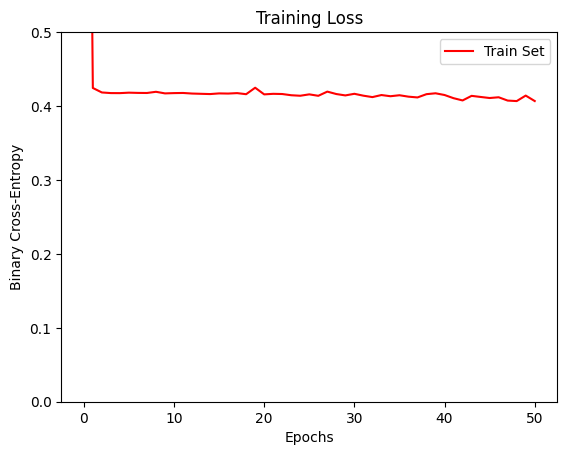

In [16]:
def forward_pass(X:np.ndarray, network:dict, output_activation=lambda x: x, activation=sigmoid_activation) -> dict:
    layers = dict()
    # as the last part we activate all the layers
    layers[0] = X @ network[0]["W"] + network[0]["b"].T
    
    for i in range(1, len(network)):
        layers[i] = activation(layers[i-1]) @ network[i]["W"] + network[i]["b"].T
    #  Abd apply a output function to the last layer
    layers[len(network)-1] = output_activation(layers[len(network)-1])
    return layers

def backpropagation(X:np.ndarray, y:np.ndarray, network:dict, layers:dict,
                    wd:float, lr:float, activation=sigmoid_activation, Der_activation=sigmoid_derivative) -> dict:
    # Start by calculating the fisrt error
    error = layers[len(layers)-1] - y
    # And the the same as in the previous part
    for layer in range(len(layers)-1, 0, -1):
        gradient_w = activation(layers[layer-1]).T @ error
        gradient_b = np.sum(error, axis=0).reshape(-1, 1)
        
        network[layer]["W"] -= lr * (gradient_w + wd * network[layer]["W"])
        network[layer]["b"] -= lr * gradient_b
        
        error = (error @ network[layer]["W"].T) * Der_activation(layers[layer-1])

    gradient_w = X.T @ error
    gradient_b = np.sum(error, axis=0).reshape(-1, 1)

    network[0]["W"] -= lr * (gradient_w + wd * network[0]["W"])
    network[0]["b"] -= lr * gradient_b

    return network

def classification_network(X:np.ndarray, y_real:np.ndarray, layers:list,
                           weight_decay:float, epochs:int=50, lr:float=0.01) -> dict:
    network = dict()
    # Initialize the layers 
    network[0] = gen_weights_bias(X.shape[1], layers[0])
    if len(layers) > 1:
        for i in range(1, len(layers)):
            network[i] = gen_weights_bias(layers[i-1], layers[i])

    network[len(layers)] = gen_weights_bias(layers[-1], y_real.shape[1])
        
    loss_historic = list()
    # Get the error withou training
    loss_current = cross_entropy(get_output_network(X, network, sigmoid_activation), y_real)
    loss_historic.append(loss_current)


    for epoch in range(epochs):
        # Permutate the indices to exclude a vies
        indices = np.random.permutation(len(X))
        X_permuted = X[indices]
        y_permuted = y_real[indices]

        # Start the Stochastic Gradient Descendent method
        for i in range(len(X)):
            # Get x and y samples as a line vector
            x_sample = X_permuted[i].reshape(1, -1)
            y_sample = y_permuted[i].reshape(1, -1)
            # Do the forward pass to the layers
            layers_actived = forward_pass(x_sample, network, sigmoid_activation)
            # Start the backpropagation algorithm in the network
            network = backpropagation(x_sample, y_sample, network, layers_actived, wd=weight_decay, lr=lr)
        # Get the loss to trining set
        loss_current = cross_entropy(get_output_network(X, network, sigmoid_activation), y_real)
        loss_historic.append(loss_current)
    # Return the trained network
    return network, loss_historic

network, historic = classification_network(X_train, y_train, [128, 64, 32], 0, 50, 0.01)
print(f'Train Loss: {historic[-1]:.3f}')
plot_historic_error(historic, "Binary Cross-Entropy", 0.5)

### Weight Decay = 0

In [17]:
network1, historic = classification_network(X_train, y_train, [128, 64, 32], 0, 50, 0.01)
loss_1 = cross_entropy(get_output_network(X_val, network1, sigmoid_activation), y_val)
print(f'Train set Loss 1: {historic[-1]:.3f}\nVal set Loss 1: {loss_1:.3f}\n')

network2, historic = classification_network(X_train, y_train, [32, 64, 32], 0, 50, 0.01)
loss_2 = cross_entropy(get_output_network(X_val, network2, sigmoid_activation), y_val)
print(f'Train set Loss 2: {historic[-1]:.3f}\nVal set Loss 2: {loss_2:.3f}\n')

network3, historic = classification_network(X_train, y_train, [32, 64, 128], 0, 50, 0.01)
loss_3 = cross_entropy(get_output_network(X_val, network3, sigmoid_activation), y_val)
print(f'Train set Loss 3: {historic[-1]:.3f}\nVal set Loss 3: {loss_3:.3f}\n')

Train set Loss 1: 0.406
Val set Loss 1: 0.403

Train set Loss 2: 0.405
Val set Loss 2: 0.404

Train set Loss 3: 0.414
Val set Loss 3: 0.421



### Weight Decay = 0.01

In [18]:
network4, historic = classification_network(X_train, y_train, [128, 64, 32], 0.01, 50, 0.01)
loss_1 = cross_entropy(get_output_network(X_val, network4, sigmoid_activation), y_val)
print(f'Train set Loss 4: {historic[-1]:.3f}\nVal set Loss 4: {loss_1:.3f}\n')

network5, historic = classification_network(X_train, y_train, [32, 64, 32], 0.01, 50, 0.01)
loss_2 = cross_entropy(get_output_network(X_val, network5, sigmoid_activation), y_val)
print(f'Train set Loss 5: {historic[-1]:.3f}\nVal set Loss 5: {loss_2:.3f}\n')

network6, historic = classification_network(X_train, y_train, [32, 64, 128], 0.01, 50, 0.01)
loss_3 = cross_entropy(get_output_network(X_val, network6, sigmoid_activation), y_val)
print(f'Train set Loss 6: {historic[-1]:.3f}\nVal set Loss 6: {loss_3:.3f}\n')

Train set Loss 4: 0.417
Val set Loss 4: 0.407

Train set Loss 5: 0.418
Val set Loss 5: 0.408

Train set Loss 6: 0.442
Val set Loss 6: 0.425



### Weight Decay = 1

In [19]:
network7, historic = classification_network(X_train, y_train, [128, 64, 32], 1, 50, 0.01)
loss_1 = cross_entropy(get_output_network(X_val, network7, sigmoid_activation), y_val)
print(f'Train set Loss 7: {historic[-1]:.3f}\nVal set Loss 7: {loss_1:.3f}\n')

network8, historic = classification_network(X_train, y_train, [32, 64, 32], 1, 50, 0.01)
loss_2 = cross_entropy(get_output_network(X_val, network8, sigmoid_activation), y_val)
print(f'Train set Loss 8: {historic[-1]:.3f}\nVal set Loss 8: {loss_2:.3f}\n')

network9, historic = classification_network(X_train, y_train, [32, 64, 128], 1, 50, 0.01)
loss_3 = cross_entropy(get_output_network(X_val, network9, sigmoid_activation), y_val)
print(f'Train set Loss 9: {historic[-1]:.3f}\nVal set Loss 9: {loss_3:.3f}\n')

Train set Loss 7: 0.422
Val set Loss 7: 0.416

Train set Loss 8: 0.422
Val set Loss 8: 0.416

Train set Loss 9: 0.453
Val set Loss 9: 0.441



In [20]:
## to calculate the test set AUROC use the following code:
X_train_val = np.concatenate([X_train, X_val])
y_train_val = np.concatenate([y_train, y_val])

# Choose the best ones
weight_decay = 0
layers = [32, 64, 32]

network, historic = classification_network(X_train_val, y_train_val, layers, weight_decay, 50, 0.01)

y_pred = get_output_network(X_test, network, sigmoid_activation)
auroc = roc_auc_score(y_test, y_pred)
print(f'Auroc for Test set: {auroc}')

Auroc for Test set: 0.6199427414029898
